In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
print(the_frontier_eddies)

import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')


['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']


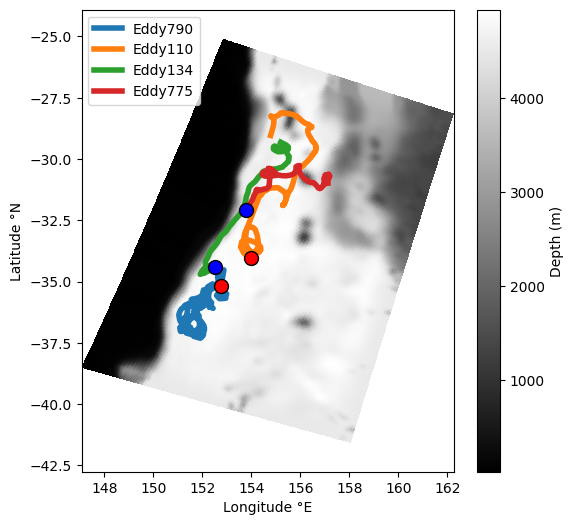

In [2]:
colors = plt.get_cmap('tab10')
plt.figure(figsize=(6, 6))
plt.pcolormesh(lon_rho, lat_rho, h, shading='auto', cmap='gray')
plt.colorbar(label='Depth (m)')
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')
for i, e in enumerate(the_frontier_eddies):
    eddy_data = eddies[e]
    plt.plot(eddy_data['Lon'], eddy_data['Lat'], color=colors(i), label=e, linewidth=4)
    plt.scatter(eddy_data['Lon'].iloc[-1], eddy_data['Lat'].iloc[-1], color='r' if eddy_data['Vort'].iloc[-1] > 0 else 'b', edgecolor='black', s=100, zorder=5)
plt.axis('equal')
plt.legend(loc='upper left')
plt.show()

In [3]:
with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
print(the_frontier_eddies)

['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']


## COWs Depth

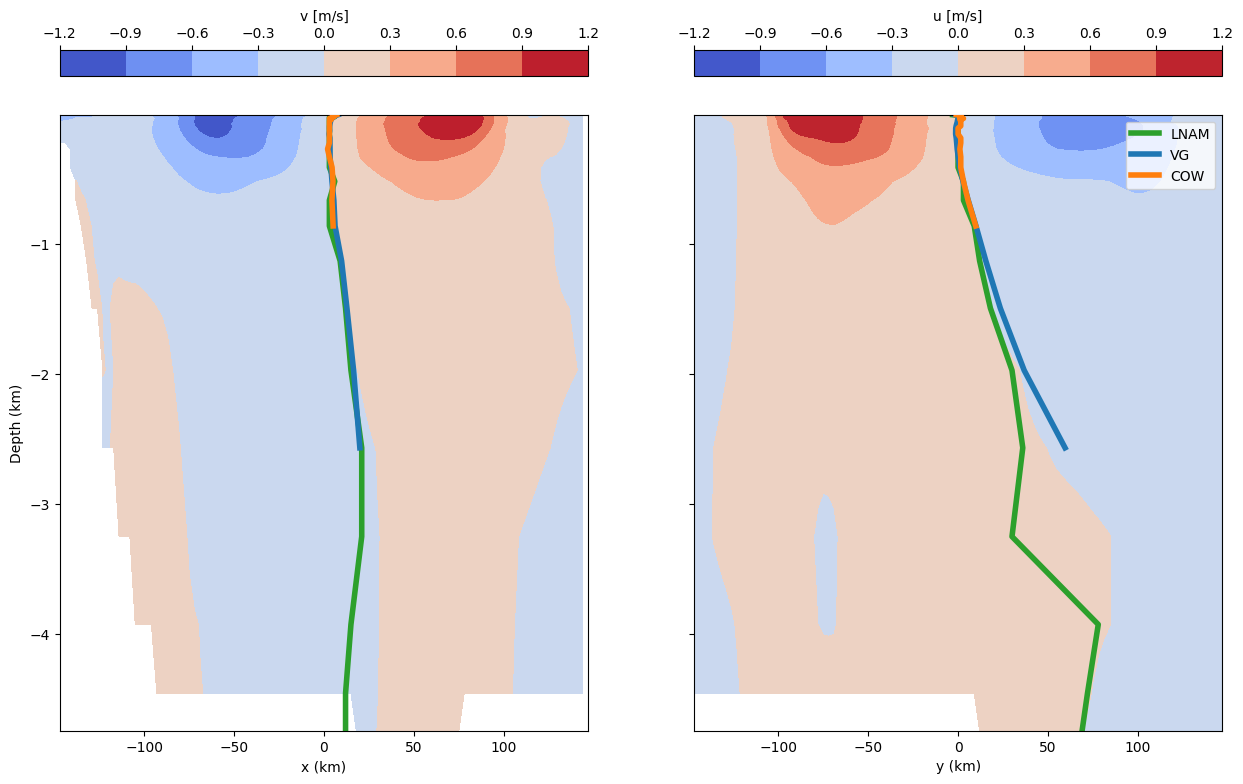

In [4]:
eddy = the_frontier_eddies[0]

t =0

U = frontier_sample_data[eddy]['T'+str(t)]['U']
V = frontier_sample_data[eddy]['T'+str(t)]['V']
x = frontier_sample_data[eddy]['T'+str(t)]['x']/1000
y = frontier_sample_data[eddy]['T'+str(t)]['y']/1000
z = frontier_sample_data[eddy]['T'+str(t)]['z']/1000
VG_data = frontier_sample_data[eddy]['T'+str(t)]['VG']
COW_data = frontier_sample_data[eddy]['T'+str(t)]['COW']
LNAM_data = frontier_sample_data[eddy]['T'+str(t)]['LNAM']

xc_VG, yc_VG, zc_VG = VG_data.x/1000, VG_data.y/1000, VG_data.Depth/1000
xc_COW, yc_COW, zc_COW = COW_data.x/1000, COW_data.y/1000, COW_data.Depth/1000
xc_LNAM, yc_LNAM, zc_LNAM = LNAM_data.x/1000, LNAM_data.y/1000, LNAM_data.Depth/1000
lengths = {
    "VG": len(zc_VG),
    "COW": len(zc_COW),
    "LNAM": len(zc_LNAM)
}
cmap = plt.colormaps['tab10']
colors = {
    "VG": cmap(0),
    "COW": cmap(1),
    "LNAM": cmap(2)
}
sorted_keys = sorted(lengths, key=lengths.get, reverse=True)



fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
X, Z = np.meshgrid(x, z)
v_data_range = np.nanmax(np.abs(V[:, V.shape[1]//2, :]))
c1 = axs[0].contourf(X, Z, V[:, V.shape[1]//2, :].T, cmap = 'coolwarm', vmin=-v_data_range, vmax=v_data_range)
for i, key in enumerate(sorted_keys):
    if key == "VG":
        axs[0].plot(xc_VG, zc_VG, linewidth=4, zorder=i+1, color=colors[key])
    elif key == "COW":
        axs[0].plot(xc_COW, zc_COW, linewidth=4, zorder=i+1, color=colors[key])
    elif key == "LNAM":
        axs[0].plot(xc_LNAM, zc_LNAM, linewidth=4, zorder=i+1, color=colors[key])
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
Y, Z = np.meshgrid(y, z)
u_data_range = np.nanmax(np.abs(U[U.shape[0]//2, :, :]))
c2 = axs[1].contourf(Y, Z, U[U.shape[0]//2, :, :].T, cmap = 'coolwarm', vmin=-u_data_range, vmax=u_data_range)
for i, key in enumerate(sorted_keys):
    if key == "VG":
        axs[1].plot(yc_VG, zc_VG, linewidth=4, zorder=i+1, label=key, color=colors[key])
    elif key == "COW":
        axs[1].plot(yc_COW, zc_COW, linewidth=4, zorder=i+1, label=key, color=colors[key])
    elif key == "LNAM":
        axs[1].plot(yc_LNAM, zc_LNAM, linewidth=4, zorder=i+1, label=key, color=colors[key])
axs[1].set_xlabel('y (km)')
# axs[1].set_ylabel('Depth (m)')
# TD = f"{round(VG_data['TD'][0]/1000)} km" if 'TD' in VG_data and not np.isnan(VG_data['TD'][0]) else 'NaN'
# plt.suptitle(f'VG - TD = {TD}')

fig.colorbar(c1, ax=axs[0], orientation='horizontal', location='top', label='v [m/s]')
fig.colorbar(c2, ax=axs[1], orientation='horizontal', location='top', label='u [m/s]')
plt.legend(loc='best')

# plt.suptitle(eddy + ' - T'+str(t))

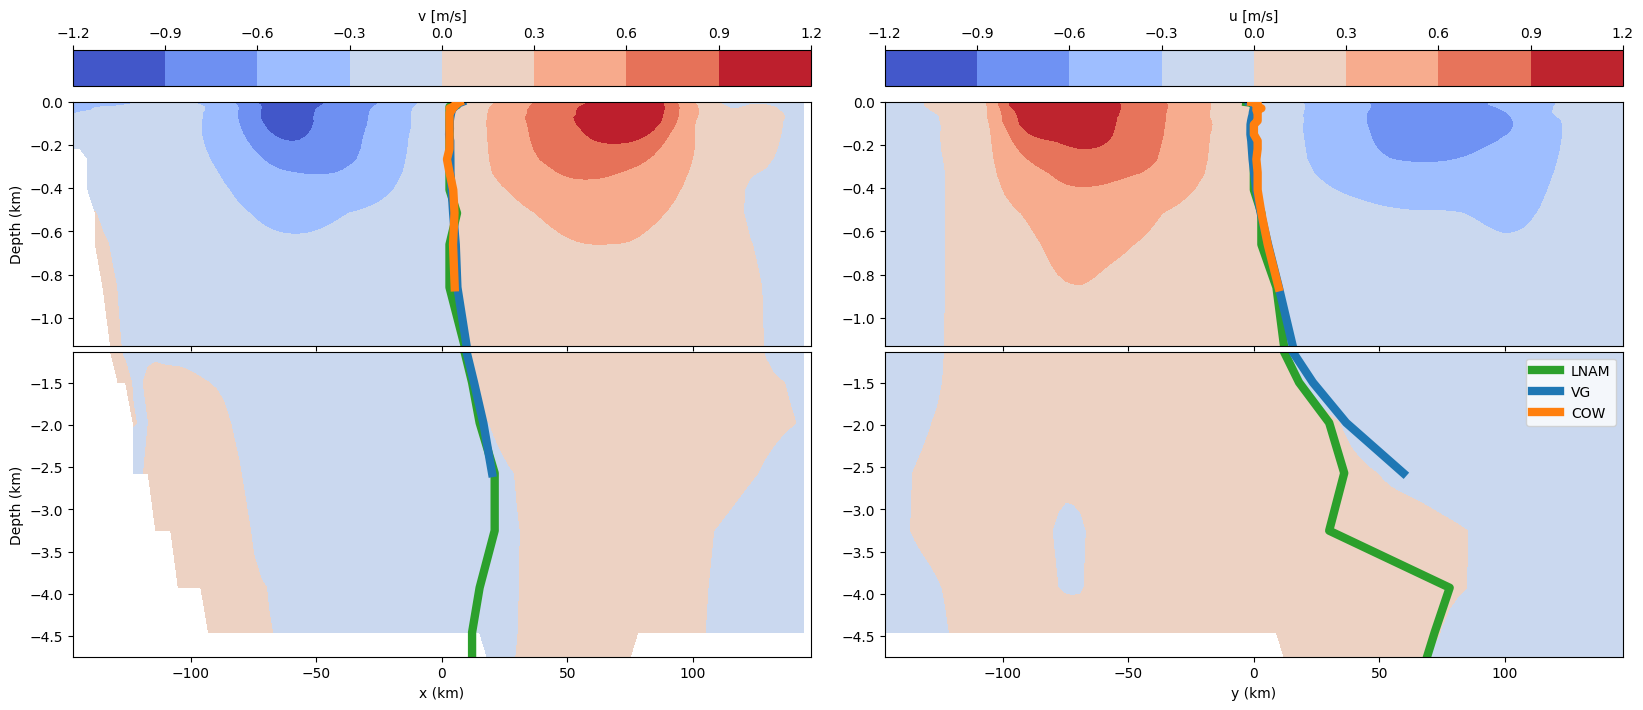

In [5]:
D1 = 23
linewidth = 6

fig, axs = plt.subplots(2, 2, figsize=(20, 8), sharex=True)
plt.subplots_adjust(hspace=0.02, wspace=0.1)  # Adjusts vertical spacing between plots
X, Z = np.meshgrid(x, z)
v_data_range = np.nanmax(np.abs(V[:, V.shape[1]//2, :]))
c1 = axs[0,0].contourf(X, Z, V[:, V.shape[1]//2, :].T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
for i, key in enumerate(sorted_keys):
    if key == "VG":
        axs[0,0].plot(xc_VG, zc_VG, linewidth=linewidth, zorder=i+1, color=colors[key])
    elif key == "COW":
        axs[0,0].plot(xc_COW, zc_COW, linewidth=linewidth, zorder=i+1, color=colors[key])
    elif key == "LNAM":
        axs[0,0].plot(xc_LNAM, zc_LNAM, linewidth=linewidth, zorder=i+1, color=colors[key])
axs[0,0].set_ylabel('Depth (km)')
axs[0,0].set_ylim([z[D1-1], 0])
# axs[0,0].set_aspect(top_aspect) 

Y, Z = np.meshgrid(y, z)
u_data_range = np.nanmax(np.abs(U[U.shape[0]//2, :, :]))
c2 = axs[0,1].contourf(Y, Z, U[U.shape[0]//2, :, :].T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
for i, key in enumerate(sorted_keys):
    if key == "VG":
        axs[0,1].plot(yc_VG, zc_VG, linewidth=linewidth, zorder=i+1, label=key, color=colors[key])
    elif key == "COW":
        axs[0,1].plot(yc_COW, zc_COW, linewidth=linewidth, zorder=i+1, label=key, color=colors[key])
    elif key == "LNAM":
        axs[0,1].plot(yc_LNAM, zc_LNAM, linewidth=linewidth, zorder=i+1, label=key, color=colors[key])
axs[0,1].set_ylim([z[D1-1], 0])
# axs[0,1].set_aspect(top_aspect) 

fig.colorbar(c1, ax=axs[0,0], orientation='horizontal', location='top', label='v [m/s]')
fig.colorbar(c2, ax=axs[0,1], orientation='horizontal', location='top', label='u [m/s]')

D1 -= 1

X, Z = np.meshgrid(x, z)
c1 = axs[1,0].contourf(X, Z, V[:, V.shape[1]//2, :].T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
for i, key in enumerate(sorted_keys):
    if key == "VG":
        axs[1,0].plot(xc_VG, zc_VG, linewidth=linewidth, zorder=i+1, color=colors[key])
    elif key == "COW":
        axs[1,0].plot(xc_COW, zc_COW, linewidth=linewidth, zorder=i+1, color=colors[key])
    elif key == "LNAM":
        axs[1,0].plot(xc_LNAM, zc_LNAM, linewidth=linewidth, zorder=i+1, color=colors[key])
axs[1,0].set_xlabel('x (km)')
axs[1,0].set_ylabel('Depth (km)')
axs[1,0].set_ylim([z[-1], z[D1]])
# axs[1,0].set_aspect(btm_aspect)  # Increase squishing by setting a lower aspect ratio


Y, Z = np.meshgrid(y, z)
c2 = axs[1,1].contourf(Y, Z, U[U.shape[0]//2, :, :].T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
for i, key in enumerate(sorted_keys):
    if key == "VG":
        axs[1,1].plot(yc_VG, zc_VG, linewidth=linewidth, zorder=i+1, label=key, color=colors[key])
    elif key == "COW":
        axs[1,1].plot(yc_COW, zc_COW, linewidth=linewidth, zorder=i+1, label=key, color=colors[key])
    elif key == "LNAM":
        axs[1,1].plot(yc_LNAM, zc_LNAM, linewidth=linewidth, zorder=i+1, label=key, color=colors[key])
axs[1,1].set_xlabel('y (km)')
axs[1,1].set_ylim([z[-1], z[D1]])
# axs[1,1].set_aspect(btm_aspect)  # Increase squishing by setting a lower aspect ratio


plt.legend(loc='best')


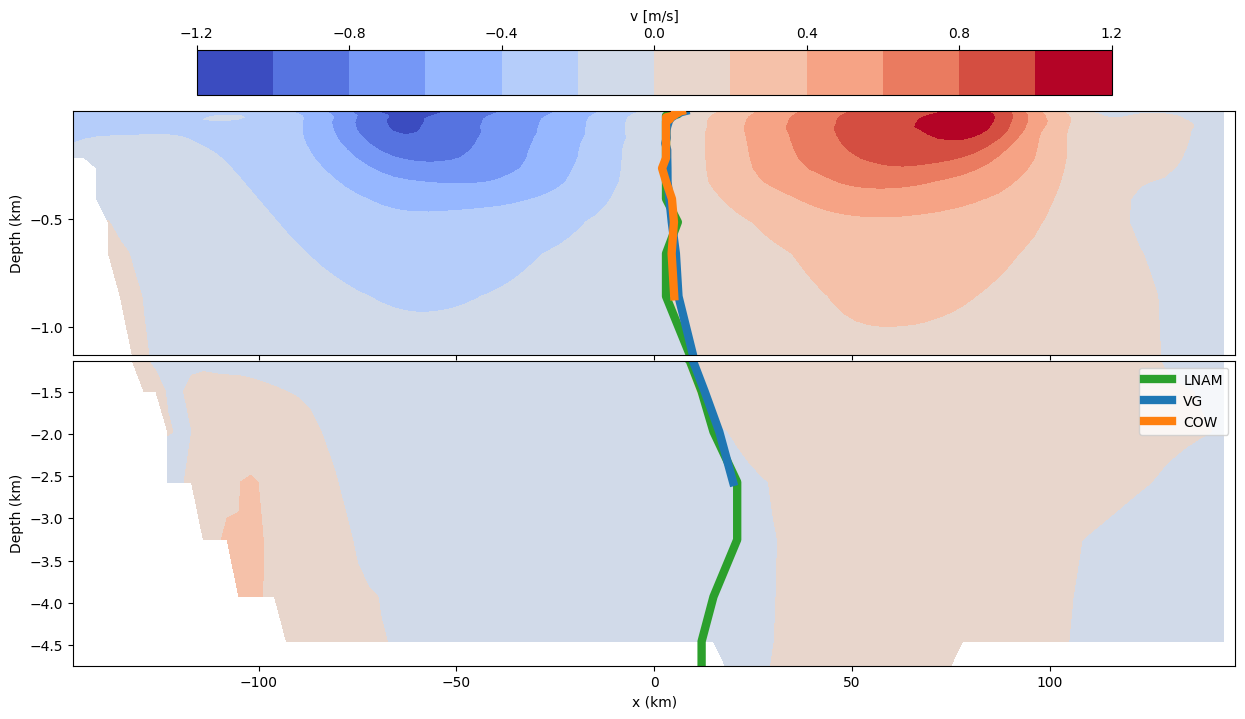

In [6]:
D1 = 23
linewidth = 6
lvls = 10

# Adjust subplots to only have 2 rows and 1 column (left side only)
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
plt.subplots_adjust(hspace=0.02)  # Adjusts vertical spacing between plots

X, Z = np.meshgrid(x, z)
v_data_range = np.nanmax(np.abs(V[:, V.shape[1]//2, :]))
c1 = axs[0].contourf(X, Z, V[:, V.shape[1]//2, :].T, lvls, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
for i, key in enumerate(sorted_keys):
    if key == "VG":
        axs[0].plot(xc_VG, zc_VG, linewidth=linewidth, zorder=i+1, color=colors[key])
    elif key == "COW":
        axs[0].plot(xc_COW, zc_COW, linewidth=linewidth, zorder=i+1, color=colors[key])
    elif key == "LNAM":
        axs[0].plot(xc_LNAM, zc_LNAM, linewidth=linewidth, zorder=i+1, color=colors[key])
axs[0].set_ylabel('Depth (km)')
axs[0].set_ylim([z[D1-1], 0])

# Set y-ticks for the first plot
axs[0].set_yticks(np.arange(round(z[D1-1] * 2) / 2, 0, 0.5))

fig.colorbar(c1, ax=axs[0], orientation='horizontal', location='top', label='v [m/s]')

D1 -= 1

X, Z = np.meshgrid(x, z)
c1 = axs[1].contourf(X, Z, V[:, V.shape[1]//2, :].T, lvls, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
for i, key in enumerate(sorted_keys):
    if key == "VG":
        axs[1].plot(xc_VG, zc_VG, linewidth=linewidth, zorder=i+1, color=colors[key], label=key)
    elif key == "COW":
        axs[1].plot(xc_COW, zc_COW, linewidth=linewidth, zorder=i+1, color=colors[key], label=key)
    elif key == "LNAM":
        axs[1].plot(xc_LNAM, zc_LNAM, linewidth=linewidth, zorder=i+1, color=colors[key], label=key)
axs[1].set_xlabel('x (km)')
axs[1].set_ylabel('Depth (km)')
axs[1].set_ylim([z[-1], z[D1]])

# Set y-ticks for the second plot
axs[1].set_yticks(np.arange(round(z[-1] * 2) / 2, round(z[D1] * 2) / 2, 0.5))

axs[1].legend(loc='best')
# axs[1].grid(True)
# axs[0].grid(True)

plt.show()


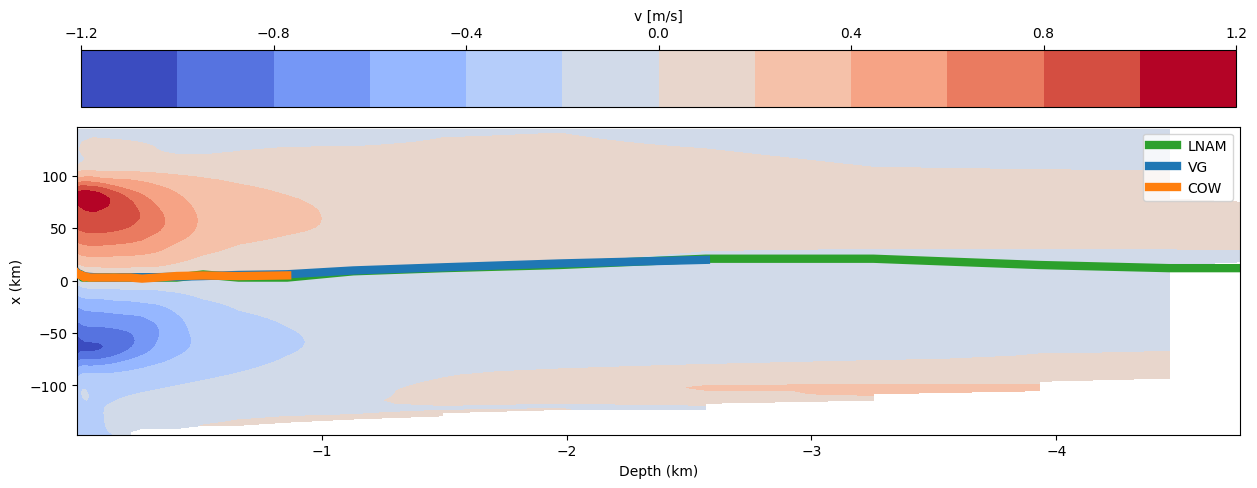

In [7]:
fig, ax = plt.subplots(figsize=(15, 5)) 
linewidth = 6
lvl = 10
X, Z = np.meshgrid(x, z)
v_data_range = np.nanmax(np.abs(V[:, V.shape[1]//2, :]))
c1 = ax.contourf(Z, X, V[:, V.shape[1]//2, :].T, lvls, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)  # Swap X and Z
for i, key in enumerate(sorted_keys):
    if key == "VG":
        ax.plot(zc_VG, xc_VG, linewidth=linewidth, zorder=i+1, color=colors[key], label=key)
    elif key == "COW":
        ax.plot(zc_COW, xc_COW, linewidth=linewidth, zorder=i+1, color=colors[key], label=key)
    elif key == "LNAM":
        ax.plot(zc_LNAM, xc_LNAM, linewidth=linewidth, zorder=i+1, color=colors[key], label=key)
ax.set_xlabel('Depth (km)')
ax.set_ylabel('x (km)') 
ax.invert_xaxis()

fig.colorbar(c1, ax=ax, orientation='horizontal', location='top', label='v [m/s]')
plt.legend(loc='best')


In [8]:
sorted_keys

['LNAM', 'VG', 'COW']

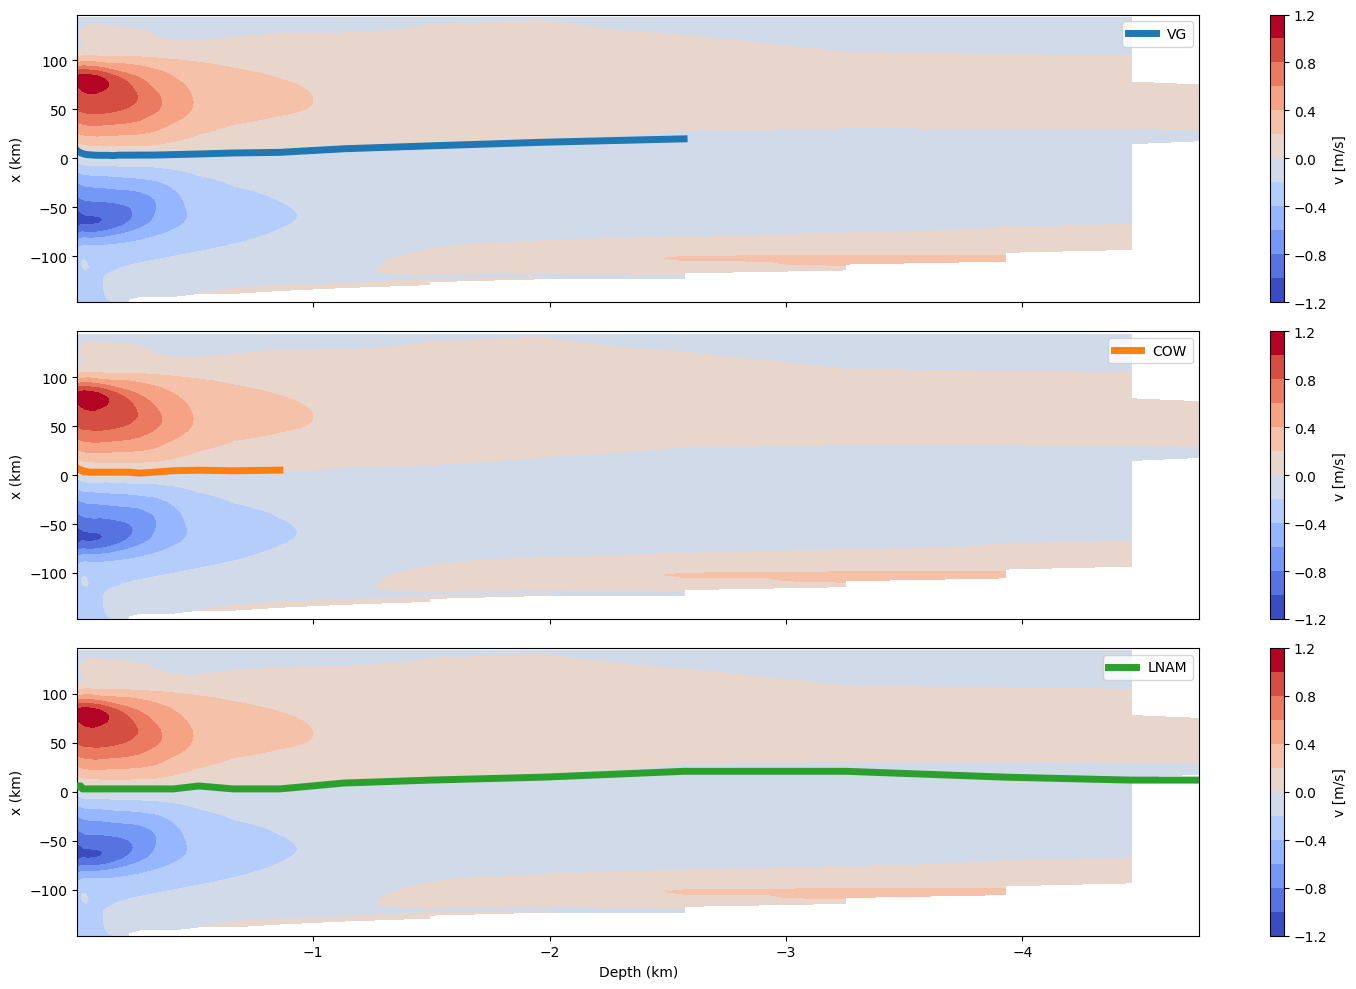

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)  # Create 3x1 grid of subplots

linewidth = 5
lvl = 10
X, Z = np.meshgrid(x, z)
v_data_range = np.nanmax(np.abs(V[:, V.shape[1]//2, :]))

# Loop through the three axes and plot each method
for i, key in enumerate(['VG', 'COW', 'LNAM']):
    ax = axes[i]  # Select the subplot for each method
    
    # Contour plot
    c1 = ax.contourf(Z, X, V[:, V.shape[1]//2, :].T, lvl, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)  # Swap X and Z
    
    # Plot the specific method on the corresponding subplot
    if key == "VG":
        ax.plot(zc_VG, xc_VG, linewidth=linewidth, zorder=i+1, color=colors[key], label=key)
    elif key == "COW":
        ax.plot(zc_COW, xc_COW, linewidth=linewidth, zorder=i+1, color=colors[key], label=key)
    elif key == "LNAM":
        ax.plot(zc_LNAM, xc_LNAM, linewidth=linewidth, zorder=i+1, color=colors[key], label=key)
    
    # Set labels and invert x-axis for each subplot
    if i == 2:
        ax.set_xlabel('Depth (km)')
    ax.set_ylabel('x (km)')
    ax.invert_xaxis()
    ax.legend(loc='best')

    # Add colorbar to the top of each subplot
    fig.colorbar(c1, ax=ax, orientation='vertical', location='right', label='v [m/s]')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



## Summary Plot

In [10]:
d_dic = {}
for eddy in the_frontier_eddies:
    d_df = pd.DataFrame()
    for t in range(30):
        df = frontier_sample_data[eddy]['T'+str(t)]['COW']['x']
        d_df['T'+str(t)] = [df.isna().idxmax() if df.isna().any() else len(df)]
    d_dic[eddy] = d_df

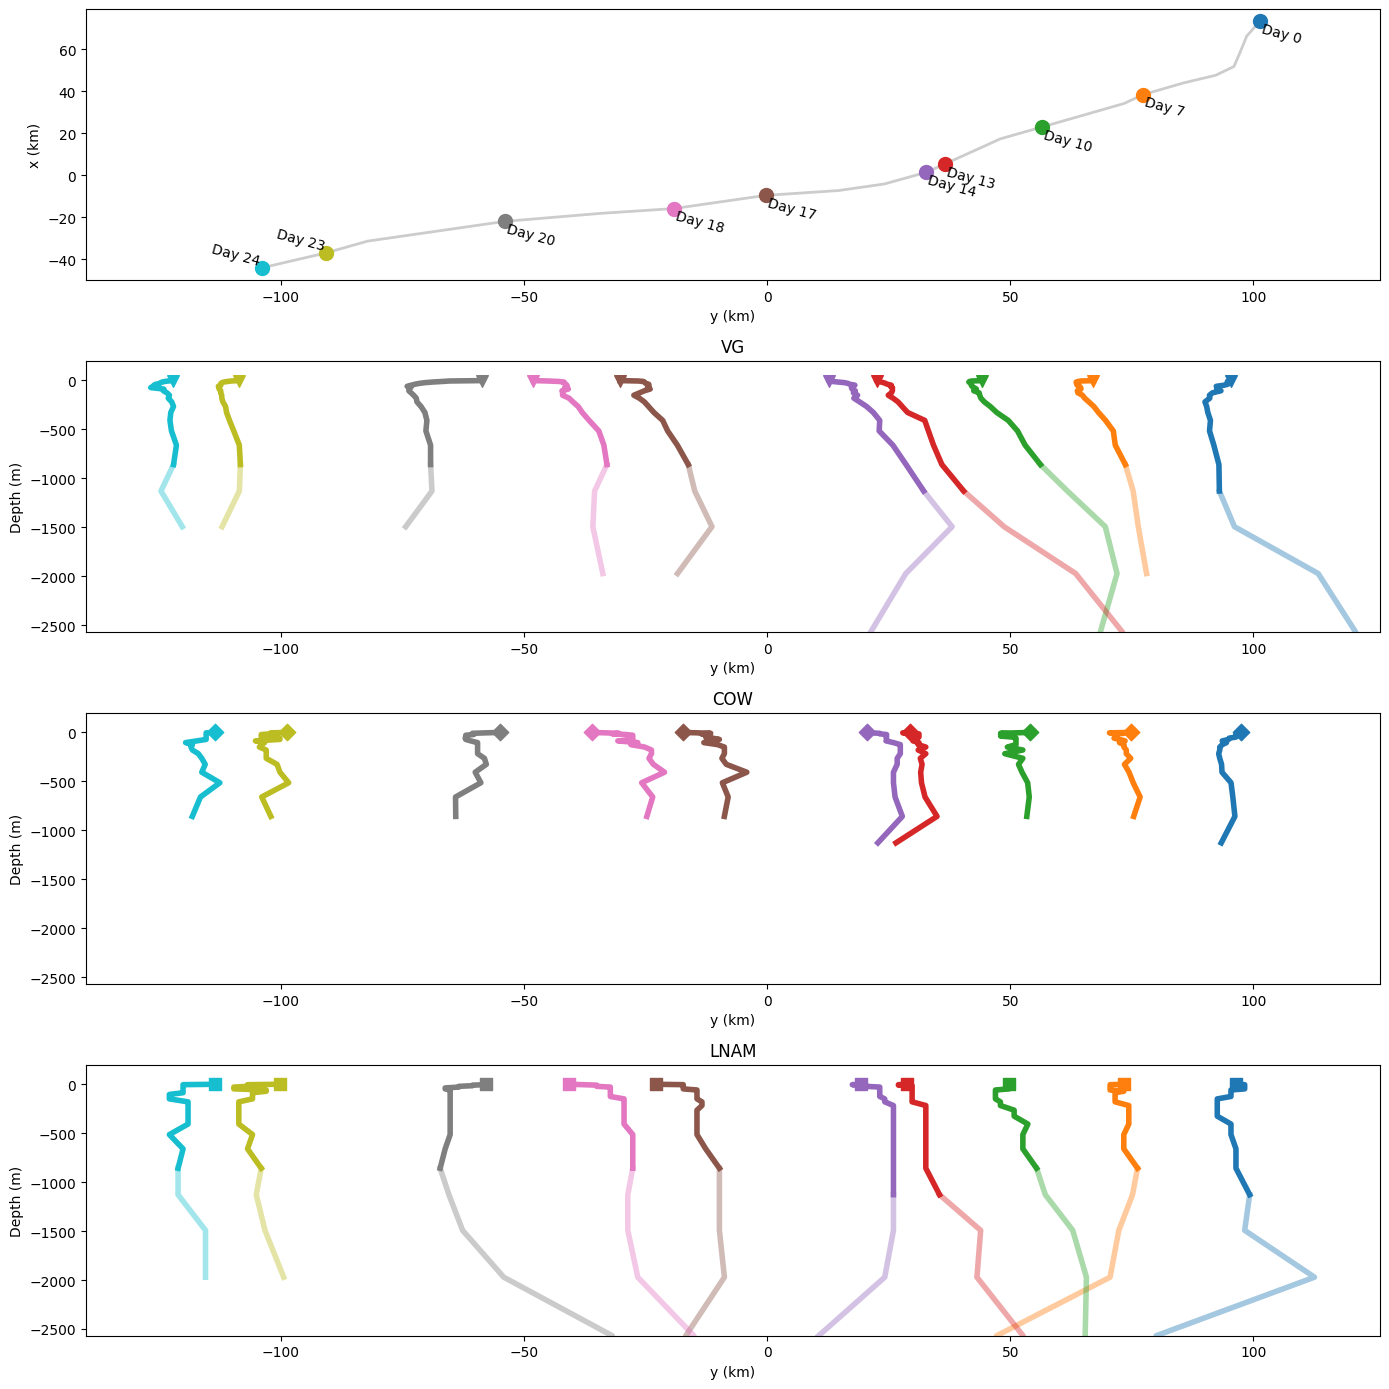

In [11]:
import matplotlib.cm as cm
def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y

def rotate_20_clockwise(x, y):
    theta = np.deg2rad(20)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated/1000, y_rotated/1000

fig, axs = plt.subplots(4, 1, figsize=(14, 14))

eddy = the_frontier_eddies[2]

DEPTH_LVL_LIMIT = 25

edata = eddies[eddy].iloc[eddies[eddy].shape[0] // 2 - 15:eddies[eddy].shape[0] // 2 + 15]
x, y = make_cartesian(edata.Lon, edata.Lat, edata.Lon.mean(), edata.Lat.mean())
eddy_path = pd.DataFrame({'x': x, 'y': y})

# t_range = range(30)
# t_range = [0,10,14,16,18,20,22,24,27, 29]
t_range = [0, 7,10,13, 14,17,18,20,23,24]

# Plot the eddy path
axs[0].plot(eddy_path.iloc[min(t_range):max(t_range)+1]['y'], eddy_path.iloc[min(t_range):max(t_range)+1]['x'], linewidth=2, color='k', alpha=.2)
axs[0].set_xlabel('y (km)')
axs[0].set_ylabel('x (km)')

y_min = float('inf')
y_max = float('-inf')
for t in t_range:
    time_data = frontier_sample_data[eddy]['T' + str(t)]['VG']
    x1, y1 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y1 = y1 + eddy_path.iloc[t].y
    time_data = frontier_sample_data[eddy]['T' + str(t)]['COW']
    x2, y2 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y2 = y2 + eddy_path.iloc[t].y
    time_data = frontier_sample_data[eddy]['T' + str(t)]['LNAM']
    x3, y3 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y3 = y3 + eddy_path.iloc[t].y
    if np.all(np.isnan(y1)):
        y1 = 0
    if np.all(np.isnan(y2)):
        y2 = 0
    if np.all(np.isnan(y3)):
        y3 = 0
    y_min = min(y_min, np.nanmin(y1), np.nanmin(y2), np.nanmin(y3), np.nanmin(eddy_path['y']))
    y_max = max(y_max, np.nanmax(y1), np.nanmax(y2), np.nanmax(y3), np.nanmax(eddy_path['y']))
y_min -= 5
y_max += 5

y_min = -140
# y_max = 15

d_df = pd.DataFrame()
for e in the_frontier_eddies:
    for t in range(30):
        df = frontier_sample_data[e]['T'+str(t)]['COW']['x']
        d_df['T'+str(t)] = [df.isna().idxmax() if df.isna().any() else len(df)]

cmap = plt.colormaps['tab10']
i = 0
alpha = .4

for t in t_range:

    axs[0].scatter(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], s=100, zorder=5)

    if t in [23, 24]:
        axs[0].text(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], 'Day ' + str(t), ha='right', va='bottom', zorder=6, rotation=-15)
    else:
        axs[0].text(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], 'Day ' + str(t), ha='left', va='top', zorder=6, rotation=-15)

    z_lim = d_dic[eddy]['T'+str(t)][0]
    
    time_data = frontier_sample_data[eddy]['T' + str(t)]['VG']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y + eddy_path.iloc[t].y
    z = time_data['Depth']
    # axs[1].plot(y, z, linewidth=4)
    axs[1].plot(y[:z_lim], z[:z_lim], linewidth=4, color=cmap(i))
    axs[1].plot(y[z_lim-1:], z[z_lim-1:], linewidth=4, alpha=alpha, color=cmap(i))
    axs[1].scatter(y[0], z[0], s=70, marker='v', color=cmap(i))
    axs[1].set_ylim([200, z_r[150, 150, DEPTH_LVL_LIMIT]])
    axs[1].invert_yaxis()
    axs[1].set_title('VG')
    axs[1].set_xlabel('y (km)')
    axs[1].set_ylabel('Depth (m)')

    time_data = frontier_sample_data[eddy]['T' + str(t)]['COW']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y + eddy_path.iloc[t].y
    z = time_data['Depth']
    axs[2].plot(y, z, linewidth=4, color=cmap(i))
    axs[2].scatter(y[0], z[0], s=70, marker='D', color=cmap(i))
    axs[2].set_ylim([200, z_r[150, 150, DEPTH_LVL_LIMIT]])
    axs[2].invert_yaxis()
    axs[2].set_title('COW')
    axs[2].set_xlabel('y (km)')
    axs[2].set_ylabel('Depth (m)')

    time_data = frontier_sample_data[eddy]['T' + str(t)]['LNAM']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y + eddy_path.iloc[t].y
    z = time_data['Depth']
    # axs[3].plot(y, z, linewidth=4)
    axs[3].plot(y[:z_lim], z[:z_lim], linewidth=4, color=cmap(i))
    axs[3].plot(y[z_lim-1:], z[z_lim-1:], linewidth=4, alpha=alpha, color=cmap(i))
    axs[3].scatter(y[0], z[0], s=70, marker='s', color=cmap(i))
    axs[3].set_ylim([200, z_r[150, 150, DEPTH_LVL_LIMIT]])
    axs[3].invert_yaxis()
    axs[3].set_title('LNAM')
    axs[3].set_xlabel('y (km)')
    axs[3].set_ylabel('Depth (m)')

    i += 1

axs[0].set_xlim(y_min, y_max)
axs[1].set_xlim(y_min, y_max)
axs[2].set_xlim(y_min, y_max)
axs[3].set_xlim(y_min, y_max)

# plt.suptitle(eddy)
plt.tight_layout()
plt.show()